# Import packages

Only one tar in the train set is used. I will split it into train test and validation set using this set.

In [13]:
import glob
import torch
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from PIL import Image
from torch.utils.data.sampler import BatchSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from skimage.io import imread, imshow
import cv2
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

cuda = torch.cuda.is_available()
torch.manual_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

images = "1IqB9R1bKlbwpoASuqOeQoyKYyuW_hbFW"
downloaded = drive.CreateFile({'id': images}) 
downloaded.GetContentFile('train_images.tar')

In [ ]:
!mkdir "images"
!tar -xf "train_images.tar" -C "images"
!rm -rf "images/0/0/8"

In [16]:
url = 'https://s3.amazonaws.com/google-landmark/metadata/train.csv'
labels = pd.read_csv(url, encoding='latin', engine='python')

In [17]:
labels = labels[labels['id'].str.contains('^00')]
labels = labels[labels['id'].str[2].isin([*'01234567'])]

In [18]:
paths = glob.glob('/content/images/*/*/*/*')
print(f'No. of Images: {len(paths)}, No. of labels: {len(labels)}')

No. of Images: 8082, No. of labels: 8082


# Image pre-processing

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
 ])

In [20]:
def get_img(id):
    return io.imread("images/"+id[0]+"/"+id[1]+"/"+id[2]+"/"+id+".jpg")

In [21]:
class glvd(Dataset):
    
    def __init__(self, train=True, transform=None):
        self.transform = transform
        self.train = train
        self.df = labels

        if self.train:
            self.grouped = self.df.groupby(self.df['landmark_id'])
        else:
            self.testf = self.df.sample(n=500).reset_index(drop=True)

    def __len__(self):
        if self.train:
            return len(self.df)
        else:
            return len(self.testf)
    
    def __getitem__(self, idx):

        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.train:
            pos_grp = self.grouped.get_group(self.df['landmark_id'].iloc[idx])
            neg_grp = pd.concat([self.df, pos_grp]).drop_duplicates(keep=False).reset_index(drop=True)
            
            ahash = self.df['id'].iloc[idx]
            Anchor = get_img(ahash)

            phash = pos_grp.sample()['id'].iloc[0]
            Positive = get_img(phash)

            nhash = neg_grp.sample()['id'].iloc[0]
            Negative = get_img(nhash)
            
            if self.transform is not None:
                Anchor = self.transform(Anchor)
                Positive = self.transform(Positive)
                Negative = self.transform(Negative)
            return (Anchor, Positive, Negative),[]

        else:
            qhash = self.testf['id'].iloc[idx]
            query = get_img(qhash)
            if self.transform is not None:
                    query = self.transform(query)
            return query
        
    def hashedvd(self,idx):
        #function to take the hashed format of image to print the query image in original form while retrieving
        return self.testf['id'].iloc[idx]

In [22]:
class glvdk(Dataset):
    
    def __init__(self, transform=None):
        self.transform = transform
        self.df = labels
        
    def __len__(self):
        return len(self.df)
        
            
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()    
        ahash = self.df['id'].iloc[idx]   
        Anchor = get_img(ahash)
            
        if self.transform is not None:
                Anchor = self.transform(Anchor)
                
        return Anchor,self.df['landmark_id'].iloc[idx] #returns training data with image tensor and labels

# Model

In [8]:
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Triplet Loss = max(pos_distance - neg_distance + margin, 0)
        distance_positive = (anchor - positive).pow(2).sum(dim=1)
        distance_negative = (anchor - negative).pow(2).sum(dim=1)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()

In [9]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        #constructing an Embedding Network 
        super(EmbeddingNet, self).__init__()
        self.convnet=torchvision.models.resnet18(pretrained=True)
        self.convnet.fc = nn.Linear(self.convnet.fc.in_features, 2)

    def forward(self, x):
        output = self.convnet(x)
        return output

    def get_embedding(self, x):
        return self.forward(x)


class EmbeddingNetL2(EmbeddingNet):
    #Applying L2 Normalisation to our Embedding Net
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(self, x):
        output = super(EmbeddingNetL2, self).forward(x)
        output /= output.pow(2).sum(1, keepdim=True).sqrt()
        return output

    def get_embedding(self, x):
        return self.forward(x)

In [10]:
class TripletNet(nn.Module):
    def __init__(self, embedding_net):
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        return self.embedding_net(x)

# Train & Validation

In [23]:
train_dataset = glvd(transform=transform)
test_dataset = glvd(train=False, transform=transform)
n_classes = 250

In [24]:
train_set_size = int(len(train_dataset) * 0.8)
valid_set_size = len(train_dataset) - train_set_size
train_dataset, valid_dataset = data.random_split(train_dataset, [train_set_size, valid_set_size])

In [25]:
def fit(train_loader, val_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[],
        start_epoch=0):
    
    for epoch in range(0, start_epoch):
        scheduler.step()

    for epoch in range(start_epoch, n_epochs):
        
        train_loss, metrics = train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics)
        
        scheduler.step()

        # Train stage
        

        message = 'Epoch: {}/{}. Train set: Average loss: {:.4f}'.format(epoch + 1, n_epochs, train_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        val_loss, metrics = test_epoch(val_loader, model, loss_fn, cuda, metrics)
        val_loss /= len(val_loader)

        message += '\nEpoch: {}/{}. Validation set: Average loss: {:.4f}'.format(epoch + 1, n_epochs,
                                                                                 val_loss)
        for metric in metrics:
            message += '\t{}: {}'.format(metric.name(), metric.value())

        print(message)

In [26]:
def train_epoch(train_loader, model, loss_fn, optimizer, cuda, log_interval, metrics):
    for metric in metrics:
        metric.reset()

    model.train()
    losses = []
    total_loss = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target if len(target) > 0 else None
        if not type(data) in (tuple, list):
            data = (data,)
        if cuda:
            data = tuple(d.cuda() for d in data)
            if target is not None:
                target = target.cuda()


        optimizer.zero_grad()
        outputs = model(*data)

        if type(outputs) not in (tuple, list):
            outputs = (outputs,)

        loss_inputs = outputs
        if target is not None:
            target = (target,)
            loss_inputs += target

        loss_outputs = loss_fn(*loss_inputs)
        loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        for metric in metrics:
            metric(outputs, target, loss_outputs)

        if batch_idx % log_interval == 0:
            
            message = 'Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data[0]), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), np.mean(losses))
            for metric in metrics:
                message += '\t{}: {}'.format(metric.name(), metric.value())

            print(message)
            losses = []

    total_loss /= (batch_idx + 1)
    return total_loss, metrics

In [27]:
def test_epoch(val_loader, model, loss_fn, cuda, metrics):
    with torch.no_grad():
        for metric in metrics:
            metric.reset()
        model.eval()
        val_loss = 0
        for batch_idx, (data, target) in enumerate(val_loader):
            target = target if len(target) > 0 else None
            if not type(data) in (tuple, list):
                data = (data,)
            if cuda:
                data = tuple(d.cuda() for d in data)
                if target is not None:
                    target = target.cuda()

            outputs = model(*data)

            if type(outputs) not in (tuple, list):
                outputs = (outputs,)
            loss_inputs = outputs
            if target is not None:
                target = (target,)
                loss_inputs += target

            loss_outputs = loss_fn(*loss_inputs)
            loss = loss_outputs[0] if type(loss_outputs) in (tuple, list) else loss_outputs
            val_loss += loss.item()

            for metric in metrics:
                metric(outputs, target, loss_outputs)

    return val_loss, metrics

In [28]:
def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels



In [29]:
def extract_embeddings_test(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        k = 0
        for images in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            k += len(images)
    return embeddings

# Final demo

In [30]:
batch_size = 8
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters(Hyperparameters Tuning)
margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)

if cuda:
    model.cuda()

loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 15
log_interval = 100

In [26]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/6465 (0%)]	Loss: 0.509690
Train: [800/6465 (12%)]	Loss: 1.092511
Train: [1600/6465 (25%)]	Loss: 0.386384
Train: [2400/6465 (37%)]	Loss: 0.464887
Train: [3200/6465 (49%)]	Loss: 0.559504
Train: [4000/6465 (62%)]	Loss: 0.463041
Train: [4800/6465 (74%)]	Loss: 0.443600
Train: [5600/6465 (87%)]	Loss: 0.441883
Train: [6400/6465 (99%)]	Loss: 0.505025
Epoch: 1/15. Train set: Average loss: 0.5433
Epoch: 1/15. Validation set: Average loss: 0.3215
Train: [0/6465 (0%)]	Loss: 0.437507
Train: [800/6465 (12%)]	Loss: 0.437134
Train: [1600/6465 (25%)]	Loss: 0.405519
Train: [2400/6465 (37%)]	Loss: 0.381759
Train: [3200/6465 (49%)]	Loss: 0.287204
Train: [4000/6465 (62%)]	Loss: 0.268984
Train: [4800/6465 (74%)]	Loss: 0.254882
Train: [5600/6465 (87%)]	Loss: 0.329754
Train: [6400/6465 (99%)]	Loss: 0.320239
Epoch: 2/15. Train set: Average loss: 0.3351
Epoch: 2/15. Validation set: Average loss: 0.3028
Train: [0/6465 (0%)]	Loss: 0.000000
Train: [800/6465 (12%)]	Loss: 0.325126
Train: [1600/6465 (25%)]	

In [33]:
train_datasetk = glvdk(transform=transform)
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_datasetk, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [34]:
train_embeddings_ocl, train_labels_ocl = extract_embeddings(train_loader, model)
test_embeddings_ocl = extract_embeddings_test(test_loader, model)

In [29]:
torch.save(model, "trained_15")

# Image retrieval

In [31]:
model = torch.load("trained_15")
model.eval()

TripletNet(
  (embedding_net): EmbeddingNet(
    (convnet): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (b

In [35]:
trnsfmk=transforms.Compose([
    transforms.ToTensor()
 ])

In [36]:
train_datasetr=glvdk(transform=trnsfmk)

Query:


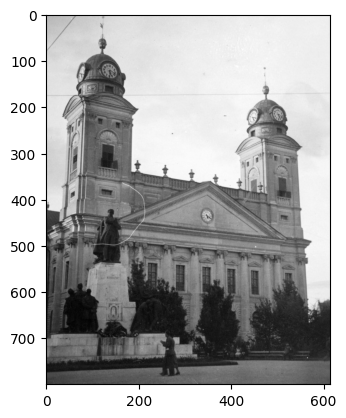

Retrieved Image:
[126758.  64916. 127176.]


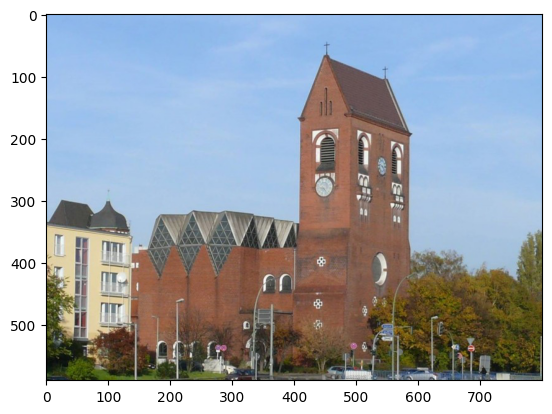

In [42]:
num_elements_to_retrieve = 3

qhash = test_dataset.hashedvd(40)
Q = get_img(qhash)

print("Query:")
plt.imshow(Q)
plt.show()

print("Retrieved Image:")

knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_embeddings_ocl, train_labels_ocl)
indexes = knn.kneighbors(test_embeddings_ocl[40:41], num_elements_to_retrieve, return_distance=False)

for index in indexes:
        print(train_labels_ocl[index])
        n=train_labels_ocl[index[1]]
        for instance,labels in train_datasetr:
            if(n==labels):
                plt.imshow(instance.permute(1,2,0))